In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns

In [2]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mouse_colors_2 = {409828: "#66CCEE", 416296: "#228833", 427836: '#CCBB44', 438833: '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = [409828, 416296, 427836, 438833]

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images_12", 
    "natural_images"
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images_12": "image_index",
    "natural_images": "image_index"
               }
multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images_12": "natural_images",
        "natural_images": "natural_images_12",
    }

chance = {
    "drifting_gratings_full": 1/12, 
    "drifting_gratings_windowed": 1/12, 
    "natural_images_12": 1/12,
    "natural_images": 1/118}

In [3]:
def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

### Bootstrapping, across 1 plane

In [4]:
#### Load the results from the decoding analyses
tag = "2025-08-13"
bootstrap_size = 50
repetitions = 1000
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

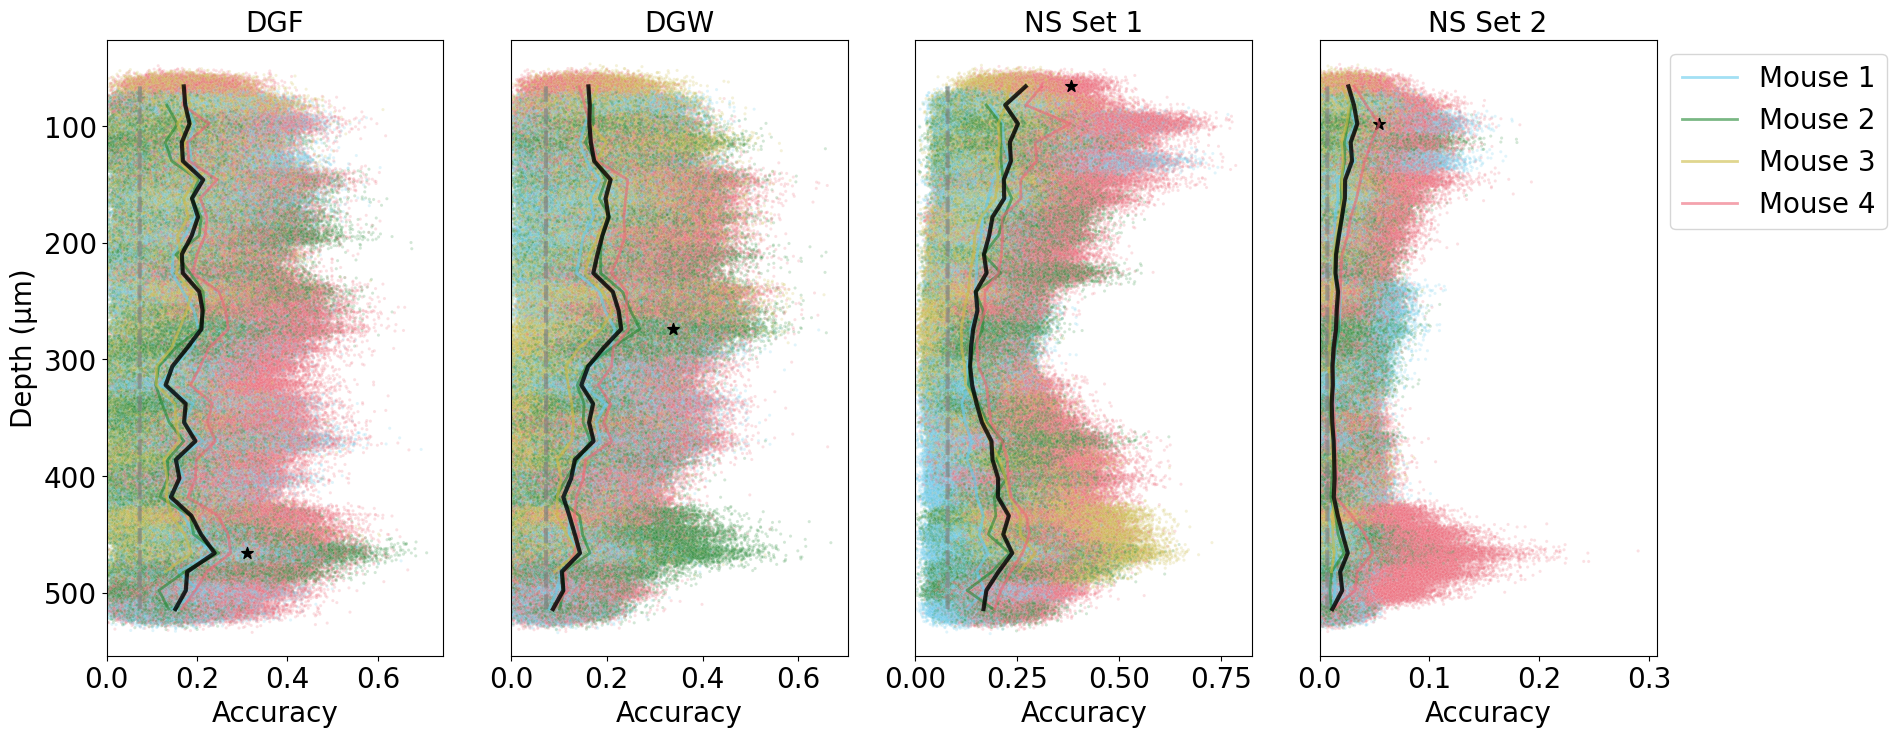

In [5]:
#### Plotting the decoding accuracies for bootstrapping, 1 plane 

# Some parameters for the plot
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515 and z_val != 500]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
n_stims = 4
jitter_amount = 5
titles = ["DGF", "DGW", "NS Set 1", "NS Set 2"]

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    temp_df = temp_df.explode('val_accuracy')
    # temp_df['val_accuracy'] = temp_df['val_accuracy'] / chance[stim_type]

    sns.lineplot(
        data=temp_df,
        x='val_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if stim_idx != 3 else True,
    )
    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == 3 else None
    
    sns.lineplot(data=temp_df, 
                    x='val_accuracy', 
                    y='depth', 
                    color='black', 
                    estimator='mean',
                    err_style='band', 
                    errorbar=('se', 2), 
                    n_boot=1000, 
                    linewidth=3, 
                    alpha=0.8, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['val_accuracy'].mean().reset_index()
    sub_array = sub_df['val_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
            color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))
    temp_df['val_accuracy'] = temp_df['val_accuracy'] + np.random.normal(0, 0.01, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x='val_accuracy',
                    y='depth',
                    hue='mouse_id',
                    palette=mouse_colors_2,
                    s=5,
                    alpha=0.2,
                    ax=ax,
                    legend=False,
                    zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_val_accuracy')
    # temp_df_shuf['shuf_val_accuracy'] = temp_df_shuf['shuf_val_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
                    x='shuf_val_accuracy', 
                    y='depth', 
                    color='grey', 
                    estimator='mean',
                    err_style='band', 
                    errorbar='se', 
                    linestyle='--',
                    linewidth=3, 
                    alpha=0.6, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    ax.set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_xlabel('Accuracy', fontsize=fontsize)
    axs[stim_idx].set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else axs[stim_idx].set_ylabel(" ")
    axs[stim_idx].set_yticks([]) if stim_idx != 0 else None
    axs[stim_idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[stim_idx].set_xlim(left=0)
    axs[stim_idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[stim_idx].invert_yaxis()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'SUPPFIG_bootstrapping_1plane_valaccuracies_decoding.png'), dpi=300)

### No bootstrapping, across 3 planes combined

In [14]:
#### Load the results from the decoding analyses
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 3
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

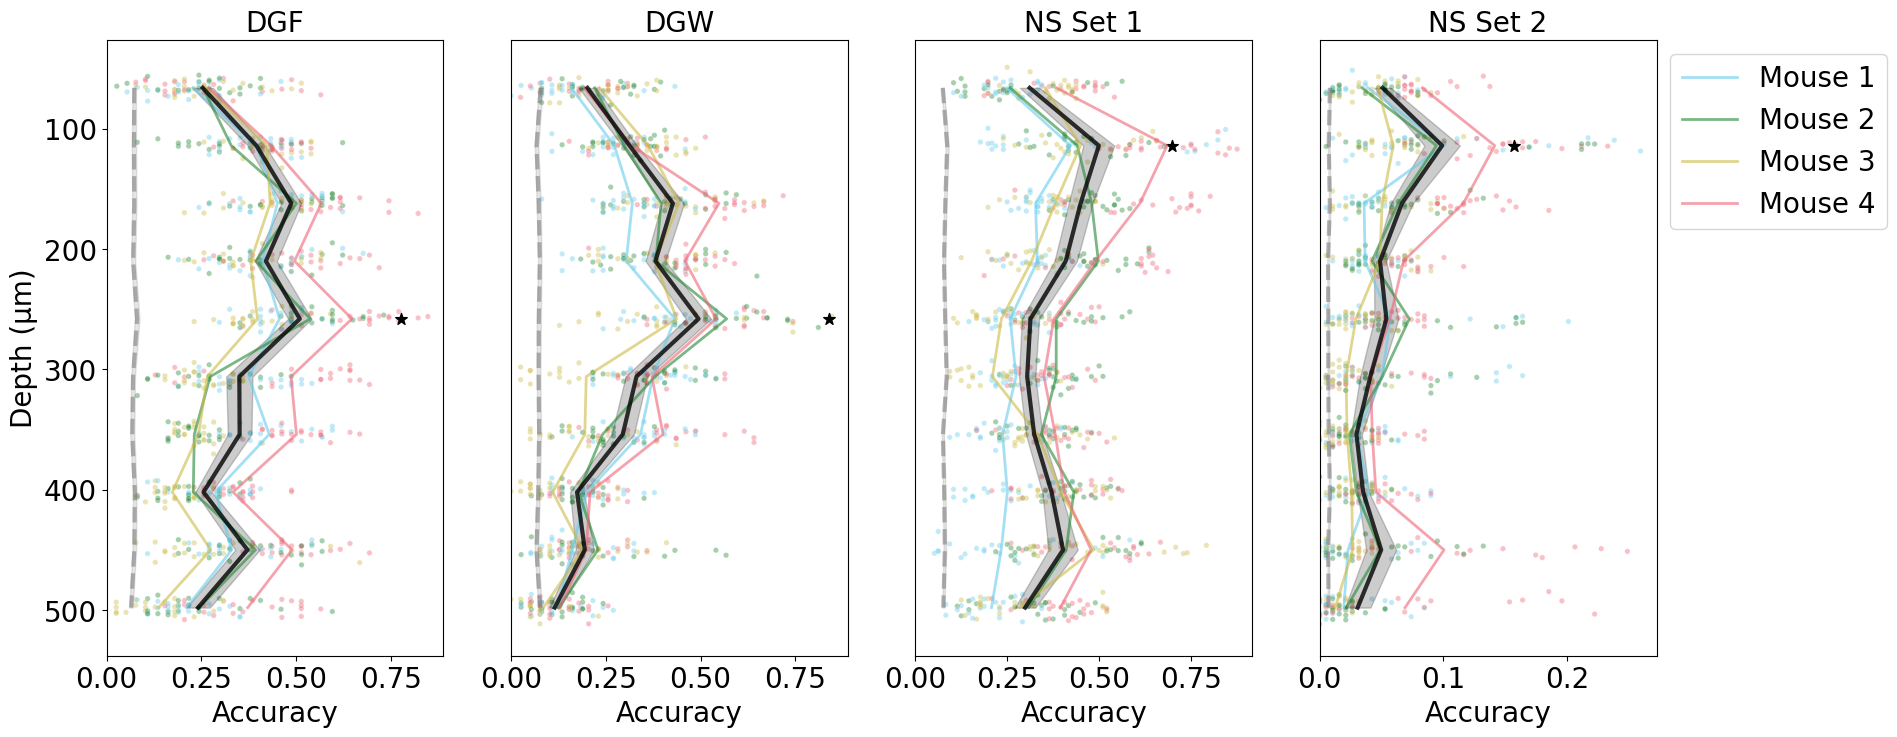

In [16]:
#### Plotting the decoding accuracies for no bootstrapping, 3 planes combined

# Some parameters for the plot
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
n_stims = 4
jitter_amount = 5
titles = ["DGF", "DGW", "NS Set 1", "NS Set 2"]

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[all_results_df['stim_type_training'] == stim_type]
    temp_df = temp_df.explode('val_accuracy')
    # temp_df['val_accuracy'] = temp_df['val_accuracy'] / chance[stim_type]

    sns.lineplot(
        data=temp_df,
        x='val_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if stim_idx != 3 else True,
    )
    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == 3 else None
    
    sns.lineplot(data=temp_df, 
                    x='val_accuracy', 
                    y='depth', 
                    color='black', 
                    estimator='mean',
                    err_style='band', 
                    errorbar=('se', 2), 
                    n_boot=1000, 
                    linewidth=3, 
                    alpha=0.8, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['val_accuracy'].mean().reset_index()
    sub_array = sub_df['val_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
            color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x='val_accuracy',
                    y='depth',
                    hue='mouse_id',
                    palette=mouse_colors_2,
                    s=15,
                    alpha=0.4,
                    ax=ax,
                    legend=False,
                    zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[all_results_df['stim_type_training'] == stim_type]
    temp_df_shuf = temp_df_shuf.explode('shuf_val_accuracy')
    # temp_df_shuf['shuf_val_accuracy'] = temp_df_shuf['shuf_val_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
                    x='shuf_val_accuracy', 
                    y='depth', 
                    color='grey', 
                    estimator='mean',
                    err_style='band', 
                    errorbar='se', 
                    linestyle='--',
                    linewidth=3, 
                    alpha=0.6, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    ax.set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_xlabel('Accuracy', fontsize=fontsize)
    axs[stim_idx].set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else axs[stim_idx].set_ylabel(" ")
    axs[stim_idx].set_yticks([]) if stim_idx != 0 else None
    axs[stim_idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[stim_idx].set_xlim(left=0)
    axs[stim_idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[stim_idx].invert_yaxis()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'SUPPFIG_nobootstrapping_3planes_valaccuracies_decoding.svg'), dpi=300)

### No bootstrapping, across 1 plane (TEST ON OTHER STIMULUS)

In [17]:
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

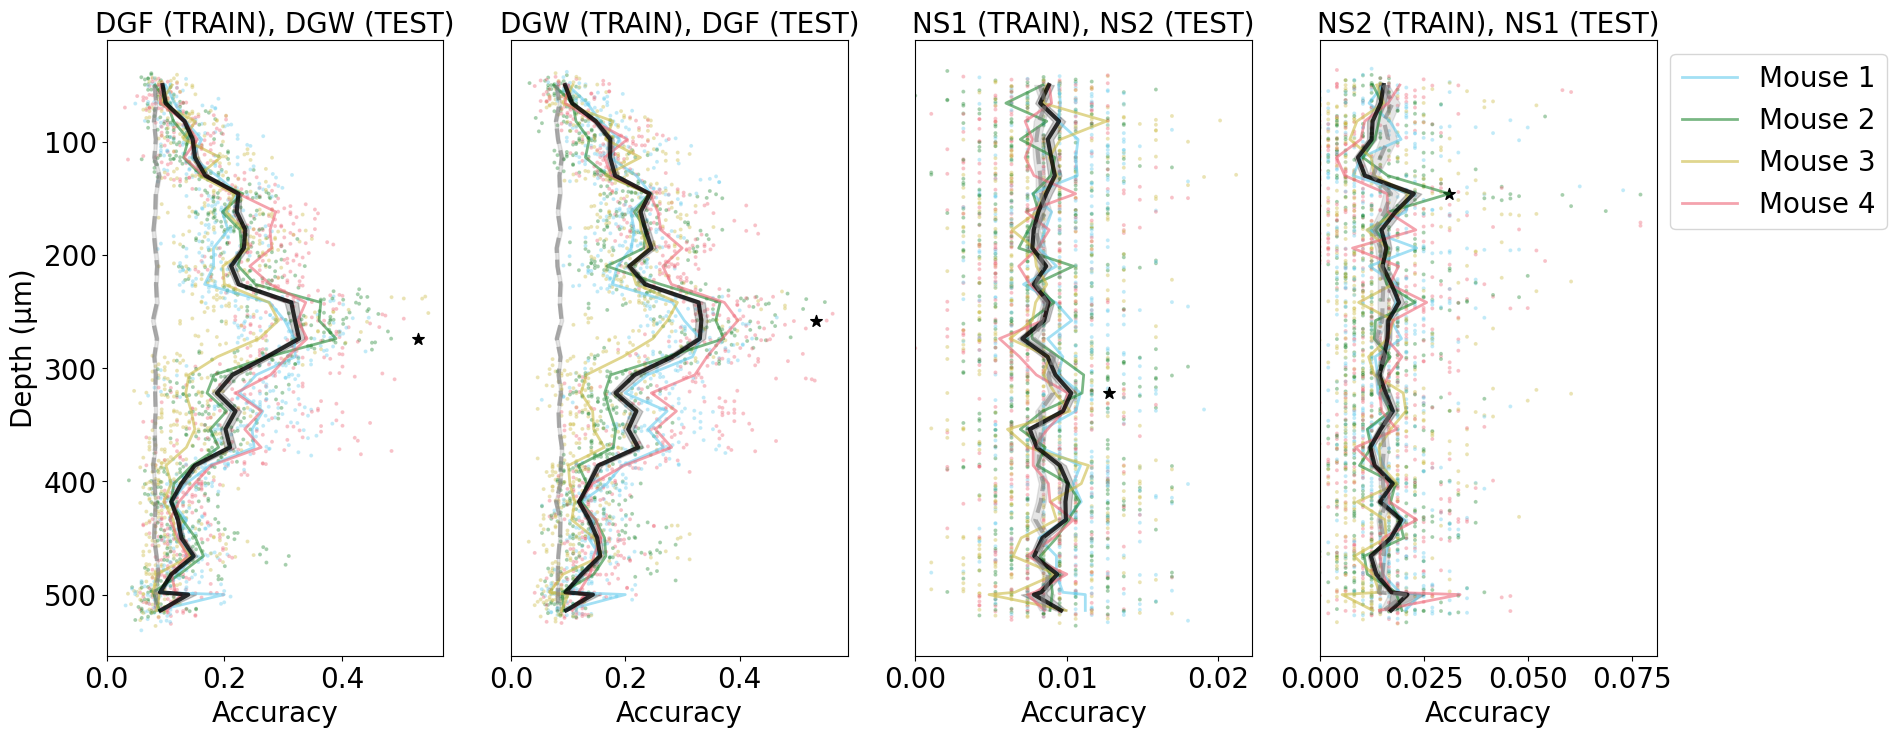

In [18]:
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
titles = [
    'DGF (TRAIN), DGW (TEST)',
    'DGW (TRAIN), DGF (TEST)',
    'NS1 (TRAIN), NS2 (TEST)',
    'NS2 (TRAIN), NS1 (TEST)'
]

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df = temp_df.explode('test_accuracy')
    # temp_df['test_accuracy'] = temp_df['test_accuracy'] / chance[stim_type]

    sns.lineplot(
        data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if stim_idx != 3 else True,
    )
    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == 3 else None

    sns.lineplot(data=temp_df, 
                    x='test_accuracy', 
                    y='depth', 
                    color='black', 
                    estimator='mean',
                    err_style='band', 
                    errorbar='se', 
                    n_boot=1000, 
                    linewidth=3, 
                    alpha=0.8, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['test_accuracy'].mean().reset_index()
    sub_array = sub_df['test_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
            color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x='test_accuracy',
                    y='depth',
                    hue='mouse_id',
                    palette=mouse_colors_2,
                    s=8,
                    alpha=0.4,
                    ax=ax,
                    legend=False,
                    zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_test_accuracy')
    # temp_df_shuf['shuf_test_accuracy'] = temp_df_shuf['shuf_test_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
                    x='shuf_test_accuracy', 
                    y='depth', 
                    color='grey', 
                    estimator='mean',
                    err_style='band', 
                    errorbar='se', 
                    linestyle='--',
                    linewidth=3, 
                    alpha=0.6, 
                    orient='y', 
                    ax=ax, 
                    legend=False)

    ax.set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_xlabel('Accuracy', fontsize=fontsize)
    axs[stim_idx].set_title(titles[stim_idx], fontsize=fontsize)
    axs[stim_idx].set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else axs[stim_idx].set_ylabel(" ")
    axs[stim_idx].set_yticks([]) if stim_idx != 0 else None
    axs[stim_idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[stim_idx].set_xlim(left=0)
    axs[stim_idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[stim_idx].invert_yaxis()

# plt.suptitle(f'Test Accuracy for no bootstrapping, {repetitions} repetitions, {num_planes} planes', fontsize=fontsize)
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'SUPPFIG_nobootstrapping_1plane_testaccuracies_decoding.svg'), dpi=300)

### No bootstrapping, across 1 plane (TEST ON OTHER STIMULUS) WITH MATCHING